In [1]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import re

import matplotlib.pyplot as plt
import numpy as np
import pickle
from ray import tune
import torch

from genome_embeddings import trainable # import before ray (?)
import ray

In [3]:
#from importlib import reload
import sys

In [4]:
settings = Namespace(
    #DATA_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/', 
    DATA_FP = '/home/ndudek/projects/def-dprecup/ndudek/',
    #SAVE_FP = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/',
    SAVE_FP = '/home/ndudek/projects/def-dprecup/ndudek/',
    num_epochs = 2,
    num_cpus=5, 
    replacement_threshold = 0.5, # probability over which binarizer converts to a 1
    num_corruptions = 100, # number of corrupted versions of a genome to produce
)

# Load data

In [5]:
# ## Figure out which genomes I want to include in my dataset
# # Use phylogenetically thinned list in selected_genomes.txt AND filter out non-bacteria
# path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/selected_kegg.txt"
# file = open(path).readlines()
# file = list(map(str.strip, file))

# # The keepers list ends up having a few genomes that do not get used
# # This is bc they have no full modules
# keepers = [] 
# # Create dict that converts tla (e.g.: Pea) -> t_num (e.g.: T321890)
# tla_to_tnum = {}

# line_counter = 0
# for s in file:
#     if line_counter < 4:
#         line_counter += 1
#         continue
#     tla = s.split()[1]
#     t_num = s.split()[2]
#     tax = s.split()[3]
    
#     if "k__Bacteria" in tax:
#         keepers.append(t_num)
#         tla_to_tnum[tla] = t_num

# print("Total number of bacterial genomes in dataset: {}".format(len(keepers)))

In [6]:
# ### load each genome as a list of KOs
# path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/annotations/annotations_list.txt"
# master_file = open(path).readlines()
# master_file = list(map(str.strip, master_file))

# ### Create dict mapping genomes to encoded KOs
# # key = t_num 
# # ko = list of all KOs annotated in genome
# org_to_kos = {}
# for i in master_file:
#     file = open("/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/annotations/"+i).readlines()
#     file = list(map(str.strip, file))
    
#     org = i.split("_")[0]
    
#     try:
#         t_num = tla_to_tnum[org]
#     except KeyError: continue # phylogenetically thinned set, not all will be present in dict (e.g. "Pea")
#     #if t_num not in keepers: continue
    
#     kos = []
#     for s in file:
#         if "<a href=" in s:
#             x = s.split()[2]
# #             if "K00668" in s:
# #                 print("s",s)
# #                 print("x", x)
# #                 print()
#             if re.match(r'[K]\d{5}', x): 
#                 kos.append(x) #[K]\d{5}
                
#     org_to_kos[t_num] = kos   

# Data exploration

In [7]:
# # Create unique list of all KOs (all_kos) 
# all_kos = []
# for t_num in org_to_kos:
#     all_kos.extend(org_to_kos[t_num])
# all_kos = list(set(all_kos))
# n_kos_tot = (len(all_kos))
# print("Total number of KOs in dataset: {}".format(n_kos_tot))

In [9]:
# # Load mapping from organism (tla, e.g.: Pea) to complete modules encoded to KOs in each module
# with open('/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/org_to_mod_to_kos.pkl', 'rb') as f:
#     org_to_mod_to_kos = pickle.load(f)

In [10]:
# # Create dict: mod_sets
# # For each module, have a counter (dict) of each unique string of KOs that can make up the module + # occurences 
# # mod_sets['M00001'] = {'K00001_K04398': 5, 'K00002_K23456': 10}
# mod_sets = defaultdict(lambda: defaultdict(int))
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         ko_str = "_".join(org_to_mod_to_kos[org][mod])
#         mod_sets[mod][ko_str] += 1

73 401


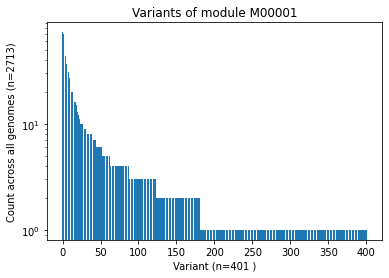

In [11]:
# mod = 'M00001'
# a = list(mod_sets[mod].values())
# a.sort(reverse=True)
# x_labels = [i for i in range(len(mod_sets[mod].values()))]
# plt.bar(x_labels, a)
# plt.yscale('log')
# plt.title("Variants of module "+mod)
# plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
# plt.ylabel("Count across all genomes (n="+str(len(org_to_mod_to_kos))+")")
# print(max(mod_sets[mod].values()), len(a))

In [12]:
# # Select most "popular" version of each module, store it in dict: mod_to_ko_clean
# # mod_to_ko_clean['M00003'] = ['K00001', 'K00002', etc] <- most common variant of M00003
# mod_to_ko_clean = {}
# for mod in mod_sets:
#     max_count = 0
#     max_path = ""
#     for ko_str in mod_sets[mod]:
#         if mod_sets[mod][ko_str] > max_count: # if there is a tie, the first one is kept 
#             max_count = mod_sets[mod][ko_str]
#             max_path = ko_str.split("_")
#     mod_to_ko_clean[mod] = max_path

## Data exploration

In [8]:
# # Sanity check: make sure that there are no "new" KOs in org_to_mod_to_kos that weren't in all_kos
# all_kos2 = []
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         all_kos2.extend(org_to_mod_to_kos[org][mod])
# all_kos2 = list(set(all_kos2))        

# for ko in all_kos2:
#     if ko not in all_kos:
#         print("missing", ko)

In [14]:
# # organism "lkm" module "M00083" has a K0 "K00668" that is specific to fungi
# # It does not appear in bacterial genomes (verified for this set) 
# # Its presence in org_to_mod_to_kos will break code later on if not removed
# bad_ko = org_to_mod_to_kos["lkm"]["M00083"].index("K00668")
# del org_to_mod_to_kos["lkm"]["M00083"][bad_ko]

Text(0.5, 1.0, 'Distribution of the # of modules (n=252) per genome (n=2713)')

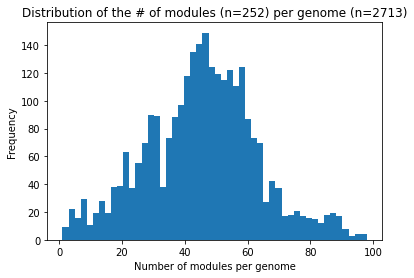

In [15]:
# # Plot the number of modules encoded by each genome
# n_genomes = len(org_to_mod_to_kos)
# temp = [list(org_to_mod_to_kos[i].keys()) for i in org_to_mod_to_kos]
# n_mods = len(list(set([item for sublist in temp for item in sublist])))
# plt.hist([len(org_to_mod_to_kos[i]) for i in org_to_mod_to_kos], 50)
# plt.xlabel("Number of modules per genome")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")

In [9]:
# a = [len(org_to_mod_to_kos[org]) for org in org_to_mod_to_kos]
# a.sort()
# print("There are "+str(a.count(0))+" genomes with zero modules")

# # Red
# # Rue
# # pvac
# # cgw

In [10]:
# NOTE THAT SOME GENOMES DO NOT HAVE A SINGLE MOD AND AREN'T EVEN IN THE DICT (n= 2717-2713 = 5)
# E.G.: clap 

In [11]:
# # Count and plot the number of genomes that encode each module
# mods_count = defaultdict(int)
# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         mods_count[mod] += 1
        
# plt.hist(mods_count.values(), 50)
# plt.xlabel("Number of genomes encoding each module")
# plt.ylabel("Frequency")
# plt.title("Distribution of the # of genomes (n="+str(n_genomes)+") encoding each module (n="+str(n_mods)+")")
# plt.yscale('log')
# print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))

In [19]:
# DO NOT LET INPUT BE SUPER RARE MODS
# NN SHOULD JUST MEMORIZE THAT GENOME

In [12]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in org_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(org_to_kos[tla])
#         n_mod_kos = len([org_to_mod_to_kos[org][mod] for mod in org_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [13]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in org_to_mod_to_kos:
#     for mod in org_to_mod_to_kos[org]:
#         kos_in_mods.extend(org_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [23]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in org_to_mod_to_kos:
#         for mod in org_to_mod_to_kos[org]:
#             if ko in org_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [24]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [14]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [15]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# Data pre-processing

In [ ]:
### Make dataframe (rows = genomes, columns = KOs)

# data = np.zeros(shape=(n_genomes,n_kos_tot))

# genome_order = []
# for i, org in enumerate(org_to_mod_to_kos):
#     genome_order.append(org)
#     for j in range(n_kos_tot):
#         try:
#             tla = tla_to_tnum[org]
#             if all_kos[j] in org_to_kos[tla]:
#                 data[i,j] = 1
#             else: pass
#         except:
#             print(i, org, tla, j)
            
# data = torch.tensor(data)
# torch.save(data, "/Users/natasha/Desktop/kegg_v2.pt")
# torch.save(genome_order, "/Users/natasha/Desktop/genome_order.pt")

In [ ]:
# data = torch.load("/Users/natasha/Desktop/kegg_v2.pt")
# genome_order = torch.load("/Users/natasha/Desktop/genome_order.pt")

In [ ]:
### Make new taxonomy dict, cluster_names object

In [ ]:
### Drop rare KO's?

# Re-create train-test split from before

In [ ]:
# ### Create train-test split (ideally identical to former split)
# # Old original split contains euk and arch
# import pandas as pd
# path = "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/data/uncorrupted_test_balanced.csv"
# test_orig = pd.read_csv(path, index_col=0) 
# test_genomes_orig = test_orig.index.to_list()

# train_genomes = []
# test_genomes = []
# for genome in keepers: 
#     if genome not in test_genomes_orig:
#         train_genomes.append(genome)
#     elif genome in test_genomes_orig:
#         test_genomes.append(genome)
        
# # Expected: train = 2395, test = 288
# len(train_genomes), len(test_genomes), len(train_genomes) + len(test_genomes)

In [ ]:
# def prep_data(list_genomes, all_kos, org_to_kos, mode):
#     """
#     Creates a tensor for training / test data
    
#     Arguments:
#     list_genomes (list) -- t_nums to be included in the tensor (i.e. train_genomes or test_genomes)
#     all_kos (list) -- all KOs that exist in the dataset
#     org_to_kos (dict) -- keys = t_nums, values = list of KOs encoded by genome
#     mode (str) -- used to save data to file ["test" | "train"] 
    
#     Returns:
#     data (np array) -- rows = genomes, columns = KOs, 1 = KO present in genome, 0 = KO absent in genome
#     """
#     from datetime import date
    
#     assert (mode == "test" or mode == "train")
    
#     data = np.zeros(shape=(len(list_genomes),len(all_kos)))

#     for i, t_num in enumerate(list_genomes): # org is something like 'T03060'
#         for j, ko in enumerate(all_kos):
#             if ko in org_to_kos[t_num]:
#                 data[i,j] = 1
#             else: pass

#     #tensor_data = torch.tensor(tensor_data) 
#     torch.save(data, "/Users/natasha/Desktop/kegg_v2_"+mode+"_"+str(date.today())+".pt")
    
#     return data

In [ ]:
# train_data = prep_data(train_genomes, all_kos, org_to_kos, "train")
# test_data = prep_data(test_genomes, all_kos, org_to_kos, "test")

# train_data = torch.load("/Users/natasha/Desktop/kegg_v2_train_2020-09-03.pt")
# test_data = torch.load("/Users/natasha/Desktop/kegg_v2_test_2020-09-03.pt")

In [ ]:
# train_data.shape, test_data.shape

# New corruption process

In [ ]:
# # For each genome, keep the KO's in 1-10 modules. Everything else should be zeros

# def corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla):
#     """
#     Creates corrupted + matching uncorrupted tensor of genomes, in that order
#     Note: only genomes with >= 1 module are included in the output
#     Note: uses "cleaned" modules from mod_to_ko_clean  
#         I.e. most common set of KOs per module, rather than 20 variants of each mod
    
#     Arguments:
#     train_data (tensor) -- rows = uncorrupted genomes, columns = KOs
#     train_genomes (list) -- names of genomes in train_data (e.g.: "T03060")
#     n_corrupt (int) -- number of corrupted versions to make of each genome
#     tnum_to_tla (dict) -- maps tnum (e.g.: "T03060") to tla (e.g.: "Red")
    
#     Returns:
#     output (tensor) -- corrupted + uncorrupted genomes (each genome's two versions are concatenated in a row)
#     c_train_genomes -- names of genomes in the order they appear in output
#     """
    
#     import random
    
#     # For one rep of one genome
#     def heart_of_corruption(org, n_max):
#         """
#         Creates
        
#         Arguments:
#         org (str) -- tla for genome (e.g.: "aha")
#         n_max (int) -- the maximum number of mods to select for corrupted version of any given genome

#         """
#         n_mods = random.randint(1, n_max) # going to select this many mods for corrupted genome
#         keeps = random.sample(list(org_to_mod_to_kos[org].keys()), n_mods)            
#         #print(org, keeps)
#         idxs = []
#         for mod in keeps:
#             for ko in org_to_mod_to_kos[org][mod]:
#             #for ko in mod_to_ko_clean[mod]:
#                 idxs.append(all_kos.index(ko))
 
#         # create corrupted version of genome that only has those mods
#         corrupted = np.zeros(n_kos_tot)
#         for i in idxs:
#             corrupted[i] = 1

#         return corrupted
    
#     output = [] 
#     c_train_genomes = []
    
#     line_counter = 0
#     for i, tnum in enumerate(train_genomes):
#         org = tnum_to_tla[tnum]
#         n_tot_mods = len(org_to_mod_to_kos[org]) # number of modules in the genome 
#         n_max = min(n_tot_mods, 10) # which is smaller: the # mods or 10
        
#         n_corrupted = 0
#         if n_tot_mods >= 1: 
#             uncorrupted = train_data[i]
#             while n_corrupted < n_corrupt: 
#                 c_train_genomes.append(org)
#                 corrupted = heart_of_corruption(org, n_max)
#                 genome_out = np.concatenate((corrupted, uncorrupted), axis=None)
#                 output.append(genome_out)
#                 line_counter += 1
#                 n_corrupted += 1
            
#     return torch.Tensor(np.array(output)), c_train_genomes

In [ ]:
#n_corrupt = settings.num_corruptions

In [ ]:
#tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}

In [ ]:
#corrupted_train, c_train_genomes = corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla)
# torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_2020-09-04.pt")

In [ ]:
# ValueError: 'K00668' is not in list

In [ ]:
#corrupted_test, c_test_genomes = corrupt(test_data, test_genomes, n_corrupt, tnum_to_tla)
# torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_2020-09-04.pt.pt")

In [ ]:
# from datetime import date
# torch.save(corrupted_train, "/Users/natasha/Desktop/corrupted_train_"+str(date.today())+".pt")
# torch.save(corrupted_test, "/Users/natasha/Desktop/corrupted_test_"+str(date.today())+".pt")

In [27]:
corrupted_train = torch.load("/Users/natasha/Desktop/corrupted_train_2020-09-09.pt")
corrupted_test = torch.load("/Users/natasha/Desktop/corrupted_test_2020-09-09.pt")

In [28]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([242600, 19748]), torch.Size([28700, 19748]))

# Define and train network

In [33]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

{}

In [100]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": settings.replacement_threshold,
         #"nn_layers": tune.choice([1, 2, 3, 4]),
          "nn_layers": tune.choice([2]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [205]:
analysis = tune.run(
    trainable.train_AE, 
    name="test_mini",
    config=config,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    num_samples=512,  #BUMP UP TO 1000
    queue_trials=True,
    stop={"test_f1": 99},
    local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    )

2020-09-18 14:04:36,863	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:36,866	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:36,867	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


epoch

2020-09-18 14:04:37,691	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

Trial name,status,loc,weight_decay,lr,batch_size,nn_layers
train_AE_69eea9a2,RUNNING,,,,,
train_AE_69eece28,PENDING,,,,,
train_AE_69eef0ec,PENDING,,,,,
train_AE_69ef1360,PENDING,,,,,
train_AE_69ef35ac,PENDING,,,,,
train_AE_69ef569a,PENDING,,,,,
train_AE_69ef7774,PENDING,,,,,
train_AE_69efa5d2,PENDING,,,,,
train_AE_69efc788,PENDING,,,,,
train_AE_69efe8b2,PENDING,,,,,


2020-09-18 14:04:39,003	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:39,004	WARNING ray_trial_executor.py:496 -- Allowing trial to start even though the cluster does not have enough free resources. Trial actors may appear to hang until enough resources are added to the cluster (e.g., via autoscaling). You can disable this behavior by specifying `queue_trials=False` in ray.tune.run().


epoch

2020-09-18 14:04:39,084	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:40,215	INFO resource_spec.py:212 -- Starting Ray with 11.08 GiB memory available for workers and up to 5.56 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:40,227	ERROR trial_runner.py:513 -- Trial train_AE_69eece28: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 459, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 377, in fetch_result
    result = ray.get(trial_future[0], DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/site-packages/ray/worker.py", line 1504, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): /usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/Resources/Python.app/Contents/MacOS/Python -m ipykernel_launcher -f /Users/nat

epoch

2020-09-18 14:04:40,326	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:41,457	INFO resource_spec.py:212 -- Starting Ray with 11.08 GiB memory available for workers and up to 5.56 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:41,458	WARNING ray_trial_executor.py:496 -- Allowing trial to start even though the cluster does not have enough free resources. Trial actors may appear to hang until enough resources are added to the cluster (e.g., via autoscaling). You can disable this behavior by specifying `queue_trials=False` in ray.tune.run().


epoch

2020-09-18 14:04:41,548	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:42,673	INFO resource_spec.py:212 -- Starting Ray with 11.08 GiB memory available for workers and up to 5.56 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:42,685	ERROR trial_runner.py:513 -- Trial train_AE_69eef0ec: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 459, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 377, in fetch_result
    result = ray.get(trial_future[0], DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/site-packages/ray/worker.py", line 1504, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): /usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/Resources/Python.app/Contents/MacOS/Python -m ipykernel_launcher -f /Users/nat

epoch

2020-09-18 14:04:42,791	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:43,913	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:43,914	WARNING ray_trial_executor.py:496 -- Allowing trial to start even though the cluster does not have enough free resources. Trial actors may appear to hang until enough resources are added to the cluster (e.g., via autoscaling). You can disable this behavior by specifying `queue_trials=False` in ray.tune.run().


epoch

2020-09-18 14:04:44,006	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

Trial name,status,loc,weight_decay,lr,batch_size,nn_layers
train_AE_69ef1360,ERROR,,,,,
train_AE_69eef0ec,ERROR,,,,,
train_AE_69eece28,ERROR,,,,,
train_AE_69eea9a2,ERROR,,,,,
train_AE_69ef569a,RUNNING,,,,,
train_AE_69ef35ac,RUNNING,,,,,
train_AE_69ef7774,PENDING,,,,,
train_AE_69efa5d2,PENDING,,,,,
train_AE_69efc788,PENDING,,,,,
train_AE_69efe8b2,PENDING,,,,,


2020-09-18 14:04:45,133	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:45,145	ERROR trial_runner.py:513 -- Trial train_AE_69ef569a: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 459, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 377, in fetch_result
    result = ray.get(trial_future[0], DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/site-packages/ray/worker.py", line 1504, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): /usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/Resources/Python.app/Contents/MacOS/Python -m ipykernel_launcher -f /Users/nat

epoch

2020-09-18 14:04:45,251	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:46,374	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:46,375	WARNING ray_trial_executor.py:496 -- Allowing trial to start even though the cluster does not have enough free resources. Trial actors may appear to hang until enough resources are added to the cluster (e.g., via autoscaling). You can disable this behavior by specifying `queue_trials=False` in ray.tune.run().


epoch

2020-09-18 14:04:46,468	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:47,592	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:47,604	ERROR trial_runner.py:513 -- Trial train_AE_69ef7774: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/trial_runner.py", line 459, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/ray_trial_executor.py", line 377, in fetch_result
    result = ray.get(trial_future[0], DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.7/site-packages/ray/worker.py", line 1504, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(TuneError): /usr/local/Cellar/python/3.7.6_1/Frameworks/Python.framework/Versions/3.7/Resources/Python.app/Contents/MacOS/Python -m ipykernel_launcher -f /Users/nat

epoch

2020-09-18 14:04:47,707	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

2020-09-18 14:04:49,055	INFO resource_spec.py:212 -- Starting Ray with 11.13 GiB memory available for workers and up to 5.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-18 14:04:49,056	WARNING ray_trial_executor.py:496 -- Allowing trial to start even though the cluster does not have enough free resources. Trial actors may appear to hang until enough resources are added to the cluster (e.g., via autoscaling). You can disable this behavior by specifying `queue_trials=False` in ray.tune.run().


epoch

2020-09-18 14:04:49,139	ERROR function_runner.py:99 -- Runner Thread raised error.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
    event_pipe = self._local.event_pipe
AttributeError: '_thread._local' object has no attribute 'event_pipe'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 93, in run
    self._entrypoint()
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 141, in entrypoint
    return self._trainable_func(config, self._status_reporter)
  File "/usr/local/lib/python3.7/site-packages/ray/tune/function_runner.py", line 257, in _trainable_func
    output = train_func(config, reporter)
  File "/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/genome_embeddings/trainable.py", line 392, in train_AE
    print("epoch",epoch, "batc

KeyboardInterrupt: 

In [ ]:
print("Best config is:", analysis.get_best_config(metric="test_f1"))

# Evaluate model performance